# INM430 - Tiny DS Project Progress Report


***

**Student Name:** Victor Ceballos Espinosa

**Project Title:** League of Legends. Climbing to Challenger

***




## Part-1: Data source and domain description (maximum 150 words):

<img src="images/lol_logo.png">
<p style="text-align: center;">Image from <a href="https://euw.leagueoflegends.com/">https://euw.leagueoflegends.com/es/</a></p>

### Domain description

League of Legends is a MOBA (Multiplayer Online Battle Arena) computer game. It was release in October 2009 by Riot Games, Inc. and since there, the number of players has been increasing until reaching 100 million players as September 2019. The game consists in two teams of 5 people who choose a champion to play with, trying to destroy the enemy team's base.

The high-end goal of the game is climbing the different leagues from bronze to challenger, where best players play. **A possible aim of this project is to find out which differs a challenger player from the ones in lower leagues**. **In addition, I want to find out if it is possible to identify boosted accounts.**

### Data source

The data source consists in an <a href="https://developer.riotgames.com/">api</a> provided by Riot Games.

***


## Part-2: Analysis Strategy and Plans (maximum 200 words):


As the data source is an API, initially I  will use the _requests_ library to query the API and get the data from different endpoints. This data will be retrieved in a JSON format so I will have to transform it into a dataframe with the variables needed for the analysis. After this, and because of the fact that from different endpoints different kind of information can be retrieved, it will be necessary merging the dataframes created from data of the different APIs. 

From this point on, I think it will be interesting calculating the win ratio / win percentage for the best players of each league and compare them to extract some insights from there. In order to go deeper into the details, it will be necessary analyzing many matches from the best players of each league to check if there is a common behavior shared across all of them. In addition, it may be interesting checking the most-used champions in each league and what makes those champions more interesting in order to help the players to move forward higher leagues. Apart from that, it may be interesting comparing players based on other stats.

***

## Part-3: Initial investigations on the data sources (maximum 150 words): 

Some initial insights have been extracted. 

Firstly, we can say that the game is matching the players correctly. This means, that players are matched agains enemies that have the same level. We can see this in the scatter plots for each league where the more games a player plays, the win ratio tends to approach to one.

In addition, beta distributions for the probability of wining a game (wins / totalGames) have been plotted. Something curious is happening here. In lower leagues, players tend to win less than 50% of their matches. Once we start moving toward higher leagues, this probability increases until challenger in which players tend to win around 55% of the matches.

Somthing strange is happening in platinum. My hypothesis is that this is caused by paid account boostings which could alter other players game experience.

Win ratio (wins / losses) keeps increasing while moving to higher leagues.

***

## Part-4: Python code for initial investigations

In [3]:
import requests
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [4]:
apiToken = "RGAPI-62b06103-5c87-4cf8-b568-f05a7797916a"
leagues = ['BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'CHALLENGER']
divisions = ['I', 'II', 'III', 'IV']

# Retrieve data

## Get basic data for each summoner (player)

In [ ]:
def get_basic_data_for(league):
    
    result = pd.DataFrame(columns = ['wins', 'losses', 'summonerId', 'league'])
    
    for division in divisions:
        r = requests.get('https://euw1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/' + league + '/' + division + '?page=1',
             headers = {
                 "Origin": "https://developer.riotgames.com",
                 "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
                 "X-Riot-Token": apiToken,
                 "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
                 "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36"
             })

        data = DataFrame(r.json())
        data['league'] = league
        data = data[data['veteran']][['wins', 'losses', 'summonerId', 'league']]

        result = pd.concat([result, data])
    
    return result[['wins', 'losses', 'summonerId', 'league']]

In [ ]:
def get_basic_data_challenger():
    
    r = requests.get('https://euw1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5',
                headers = {
                    "Origin": "https://developer.riotgames.com",
                    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
                    "X-Riot-Token": apiToken,
                    "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
                    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
                })

    challengersData = DataFrame(list(DataFrame(r.json())['entries']))
    challengersData['league'] = 'CHALLENGER'
    return challengersData[challengersData['veteran']][['wins', 'losses', 'summonerId', 'league']]

In [ ]:
allData = pd.DataFrame()

for league in leagues:
    
    if league == 'CHALLENGER':
        allData = pd.concat([allData, get_basic_data_challenger()])
    else:    
        allData = pd.concat([allData, get_basic_data_for(league)])
        
allData['totalGames'] = allData['wins'] + allData['losses']
allData['winRatio'] = allData['wins'] / allData['losses']
allData['winPercentage'] = allData['wins'] / allData['totalGames']

## Get account ids and summoner level

In [ ]:
def get_summoner_account(summonerId):
        
    r = requests.get('https://euw1.api.riotgames.com/lol/summoner/v4/summoners/' + summonerId,
            headers = {
                "Origin": "https://developer.riotgames.com",
                "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
                "X-Riot-Token": apiToken,
                "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
                "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
            })
    
    #Becuase the API have a limit of 100 requests every 2 minutes
    time.sleep(1.4)
    
    return [summonerId, r.json().get('name'), r.json().get('accountId'), r.json().get('summonerLevel')]

In [ ]:
summoner_account_ids = list(allData['summonerId'].apply(get_summoner_account))
temporal_df = pd.DataFrame(summoner_account_ids, columns = ['summonerId', 'summonerName', 'accountId', 'summonerLevel'])
allData = allData.merge(temporal_df, on = 'summonerId', how = 'left')

## Get a match id for each summoner

In [ ]:
def get_matches_id(account_id):
    
    response = requests.get('https://euw1.api.riotgames.com/lol/match/v4/matchlists/by-account/' + str(account_id),
            headers = {
                "Origin": "https://developer.riotgames.com",
                "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
                "X-Riot-Token": apiToken,
                "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
                "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
            })
    
    #Becuase the API have a limit of 100 requests every 2 minutes
    time.sleep(2)
    print(response)
    return [account_id, response.json().get('matches')[0].get('gameId')]

In [ ]:
game_ids = pd.DataFrame(list(allData['accountId'].apply(get_matches_id)), columns = ['accountId', 'matchId'])
allData = allData.merge(game_ids, on = 'accountId', how = 'left');

## Get match history uri

In [ ]:
def get_match_uri(match_id, summoner_name):
    
    response = requests.get('https://euw1.api.riotgames.com/lol/match/v4/matches/' + str(match_id),
            headers = {
                "Origin": "https://developer.riotgames.com",
                "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
                "X-Riot-Token": apiToken,
                "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
                "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
            })

    time.sleep(2)
    players = response.json().get('participantIdentities')

    for each in players:
        if each.get('player').get('summonerName') == summoner_name:
            return [match_id, each.get('player').get('matchHistoryUri')]
    
    #Becuase the API have a limit of 100 requests every 2 minutes


In [ ]:
matchHistoryUris = list(map(lambda x: get_match_uri(*x), allData[['matchId', 'summonerName']].values))
foo = pd.DataFrame(matchHistoryUris, columns = ['matchId', 'matchHistoryUri'])

In [ ]:
allData = allData.merge(foo, on = 'matchId', how = 'left')

## Get players stats

In [6]:
def get_player_stats(matchHistoryUri):
    
    r = requests.get('https://acs.leagueoflegends.com' + matchHistoryUri,
        headers = {
            "Origin": "https://developer.riotgames.com",
            "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
            "X-Riot-Token": apiToken,
            "Accept-Language": "en,es-ES;q=0.9,es;q=0.8",
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
        })

    time.sleep(1.3)
    
    games = r.json()['games']['games']
    
    return list(map(lambda x: x['participants'][0]['stats'], games))

In [7]:
summonersStats = {}

for summonerName, matchHistoryUri in allData[['summonerName', 'matchHistoryUri']].values:
    summonersStats[summonerName] = get_player_stats(matchHistoryUri)

In [8]:
statsAverage = {}

for summonerName in summonersStats.keys():
    statsAverage[summonerName] = pd.DataFrame([[stat.get('kills'), stat.get('deaths'), stat.get('assists')] for stat in summonersStats[summonerName]]).mean()

In [9]:
statsAveragaDf = pd.DataFrame(statsAverage).transpose().reset_index()
statsAveragaDf.columns = ['summonerName', 'averageKills', 'averageDeath', 'averageAssists']
allData = allData.merge(statsAveragaDf, on = 'summonerName', how = 'left')
allData['averageKDA'] = (allData['averageKills'] + allData['averageAssists']) / allData['averageDeath']

# Analysis

## Average total games played comparison

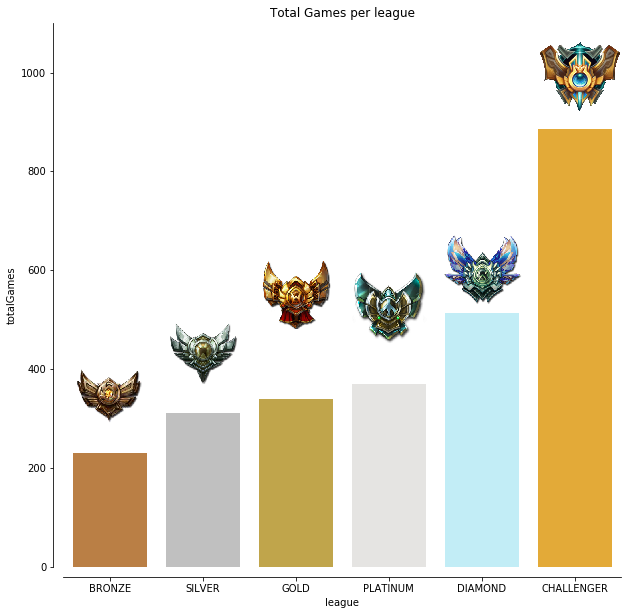

In [10]:
allData['totalGames'] = allData['totalGames'].apply(int)
totalGamesAverage = allData[['totalGames', 'league']].groupby(['league']).mean().reset_index()
totalGamesAverage['league'] = totalGamesAverage.replace({'BRONZE' : 0, 
                                                         'SILVER' : 1, 
                                                         'GOLD' : 2, 
                                                         'PLATINUM' : 3, 
                                                         'DIAMOND' : 4, 
                                                         'CHALLENGER' : 5})

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

plt.title('Total Games per league')
plt.ylim(0, 1100)

images_config = {'BRONZE' : {'image' : 'images/bronze.png', 'zoom' : 0.4, 'y' : 350}, 
                 'SILVER' : {'image' : 'images/silver.png', 'zoom' : 0.4, 'y' : 430},
                 'GOLD' : {'image' : 'images/gold.png', 'zoom' : 0.4, 'y' : 550},
                 'PLATINUM' : {'image' : 'images/platinum.png', 'zoom' : 0.4, 'y' : 530},
                 'DIAMOND' : {'image' : 'images/diamond.png', 'zoom' : 0.4, 'y' : 600},
                 'CHALLENGER' : {'image' : 'images/challenger.png', 'zoom' : 0.2, 'y' : 1000},
                }

for index, league in enumerate(leagues):
    config = images_config.get(league)
    logo = mpimg.imread(config.get('image'))
    offset_image = OffsetImage(logo, zoom=config.get('zoom'))
    ax.add_artist(AnnotationBbox(offset_image, (index, config.get('y')), frameon = False))

colors = ['#cd7f32', '#c0c0c0', '#d4af37', '#e5e4e2', '#b9f2ff', '#ffb31c']
sns.barplot(data = totalGamesAverage, x = 'league', y = 'totalGames', palette = colors)
sns.despine(offset=10);
plt.xticks(np.arange(6), leagues);

It is happening somethig strange here. We can observe that while moving forward higher leagues, from bronze to challenger, the number of played matches tends to increase. Nevertheless, in platinum, this tendency is not followed.

In League of Legends, many players pay people to boost their account, moving them from lower leagues to higher ones. This can alter the game experience of the players that have moved to these higher leagues in without boosting their accounts.

## Win ratio comparison

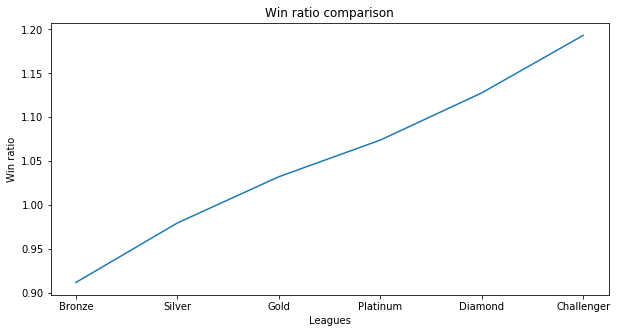

In [11]:
winRatios = [allData[allData['league'] == league]['winRatio'].median() for league in leagues]

plt.figure(figsize = (10, 5))
plt.title('Win ratio comparison')
plt.xticks(np.arange(6), list(map(lambda x: x.capitalize(), leagues)))
plt.xlabel('Leagues')
plt.ylabel('Win ratio')
plt.plot(winRatios)

Text(0, 0.5, 'Win percentage')

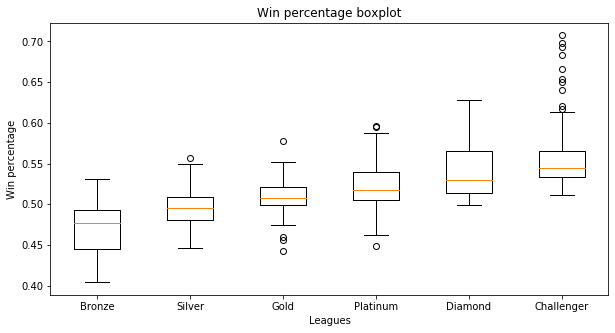

In [12]:
plt.figure(figsize = (10, 5))
plt.title('Win percentage boxplot')
plt.boxplot([allData[allData['league'] == league]['winPercentage'] for league in leagues])
plt.xticks(np.arange(6) + 1, list(map(lambda x: x.capitalize(), leagues)))
plt.xlabel('Leagues')
plt.ylabel('Win percentage')

Win ratio and win percentage seem to behave correctly. This means that higher leagues, have higher win ratio (wins / losses) and win percentage (wins / total games). Of course, this behaviour is caused by the improvement of the players. This two metrics don't support the hypothesis that accounts are been boosted to platinum.

## Beta distributions for the win percentage of every league

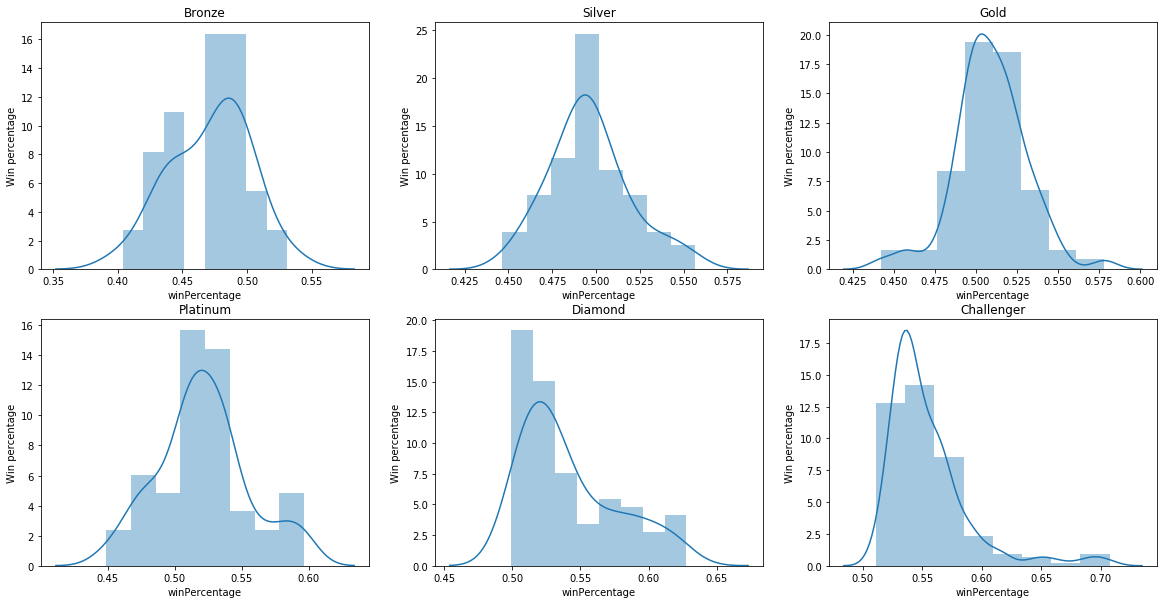

In [13]:
plt.figure(figsize = (20, 10))
for index, league in enumerate(leagues):
    plt.subplot(2, 3, index + 1)
    plt.xlabel('Leagues')
    plt.ylabel('Win percentage')
    plt.title(league.capitalize())
    sns.distplot(allData[allData['league'] == league]['winPercentage'], bins = 8)

In this combined plot, it is shown the distribution of the winning probability for each league. Something interesting is happening. From Bronze to Platinum, the probability density distributions have a bell shape. However, in Diamond and Challenger, the probability density distributions are skeed positively. In addition, summoners win at least 50% of their matches.

Even though platinum is a high league, there are still players that have less than 50% chanes of winning a match. This may reinforce the hypothesis that some account are boosted to platinum.

A possible explanation why accounts are not boosted to higher leagues like diamond or challenger could be that summoners in those leagues, are extremely good and have a tone of experience so they would recognize a boosted account just playing with or agains it.

## Average KDA

The KDA is a popular metric inside the game that is calculated as follows:

$$ \frac{Kills + Assistances}{Deaths} $$

Basically, in a game, you can kill an oponent (kills) and be killed (deaths). In addition, you can assist on killing an enemy summoner (assists).

Text(0, 0.5, 'Average KDA')

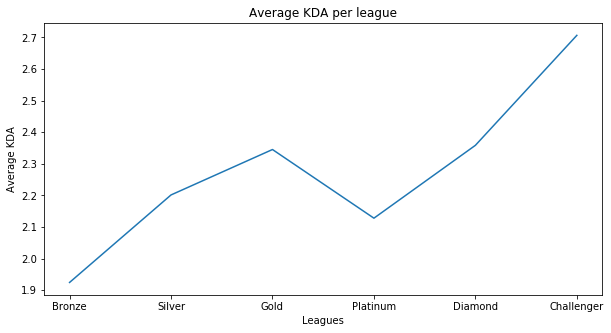

In [14]:
plt.figure(figsize = (10, 5))
plt.title('Average KDA per league')
plt.plot([allData[allData['league'] == league]['averageKDA'].median() for league in leagues])
plt.xticks(np.arange(6), list(map(lambda x: x.capitalize(), leagues)))
plt.xlabel('Leagues')
plt.ylabel('Average KDA')

As explained before, KDA is a metric than can explain very good how good a summoner knows the champions they used in the games. Players in higher leagues know better the champions they use, therefore it is expected that the average KDA for each league rises. In platinum it can be observed that the average KDA drops into a value lower than the average KDA in Gold which is the previous league. This is an indicator that the hypothesis of paid boosted accounts could be true.